# Modélisation et évaluation des modèles

**Auteur :** Mehdi MUNIM

**Date :** 2023-11-26

**Description :**

Ce notebook entraîne et évalue différents modèles de Machine Learning pour la classification de sentiment sur les données de tweets prétraitées.

## 1- Importation des librairies

In [1]:
#@title 1. Importation des librairies

# Data manipulation and processing
import pandas as pd
import numpy as np
import pickle

# Machine learning
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System and custom modules
import sys
sys.path.append('../src')
import model
import evaluation

2024-12-17 10:56:59.617317: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Chargement des données

In [2]:
#@title 2.1 Chargement des données

# Chemin d'accès au dossier data
data_path = '../data/processed/'

# Charger les données prétraitées

## Données non vectorisées
X_train = pickle.load(open(data_path + 'X_train.pickle', 'rb'))
X_test = pickle.load(open(data_path + 'X_test.pickle', 'rb'))

## Labels
y_train = pickle.load(open(data_path + 'y_train.pickle', 'rb'))
y_test = pickle.load(open(data_path + 'y_test.pickle', 'rb'))

## Vectorisées TF-IDF
X_train_tfidf = pickle.load(open(data_path + 'X_train_tfidf.pickle', 'rb'))
X_test_tfidf = pickle.load(open(data_path + 'X_test_tfidf.pickle', 'rb'))

## Word2vec
X_train_w2v = pickle.load(open(data_path + 'X_train_word2vec.pickle', 'rb'))
X_test_w2v = pickle.load(open(data_path + 'X_test_word2vec.pickle', 'rb'))


## Doc2Vec
X_train_d2v = pickle.load(open(data_path + 'X_train_doc2vec.pickle', 'rb'))
X_test_d2v = pickle.load(open(data_path + 'X_test_doc2vec.pickle', 'rb'))


## 3. Entraînement et évaluation des modèles

### 3.1 - Régression logistique (Baseline)

Accuracy: 0.6967
Precision: 0.6920
Recall: 0.6987
F1-score: 0.6953
Prediction Time: 0.0256 seconds


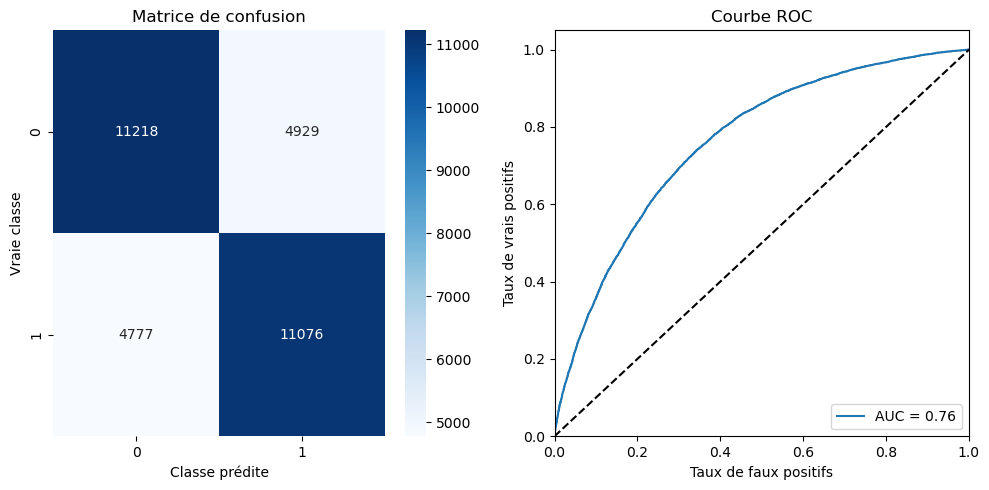

/home/mehdi/miniconda3/envs/sentiment_analysis/lib/python3.8/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/12/16 20:50:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [3]:
#@title 3.1 Entraînement et évaluation du modèle de régression logistique avec MLflow

import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression

# Créer et entraîner le modèle de régression logistique
model_lr = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_lr.fit(X_train_d2v, y_train)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lr, X_test_d2v, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 1000)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)  # Enregistrer le predict_time

    # Ajouter un tag
    mlflow.set_tag("model_name", "LogisticRegression")
    
    # Enregistrer le modèle
    mlflow.sklearn.log_model(model_lr, "model_lr")

### 3.2 - Modèle MLP

Epoch 1/10
3200/3200 [==============================] - 15s 4ms/step - loss: 0.5846 - accuracy: 0.6914 - val_loss: 0.5726 - val_accuracy: 0.7037
Epoch 2/10
3200/3200 [==============================] - 12s 4ms/step - loss: 0.5660 - accuracy: 0.7056 - val_loss: 0.5639 - val_accuracy: 0.7096
Epoch 3/10
3200/3200 [==============================] - 12s 4ms/step - loss: 0.5573 - accuracy: 0.7105 - val_loss: 0.5587 - val_accuracy: 0.7123
Epoch 4/10
3200/3200 [==============================] - 13s 4ms/step - loss: 0.5499 - accuracy: 0.7161 - val_loss: 0.5613 - val_accuracy: 0.7101
Epoch 5/10
3200/3200 [==============================] - 13s 4ms/step - loss: 0.5449 - accuracy: 0.7206 - val_loss: 0.5594 - val_accuracy: 0.7122
Epoch 6/10
3200/3200 [==============================] - 13s 4ms/step - loss: 0.5406 - accuracy: 0.7230 - val_loss: 0.5545 - val_accuracy: 0.7178
Epoch 7/10
3200/3200 [==============================] - 19s 6ms/step - loss: 0.5361 - accuracy: 0.7266 - val_loss: 0.5576 - val_ac

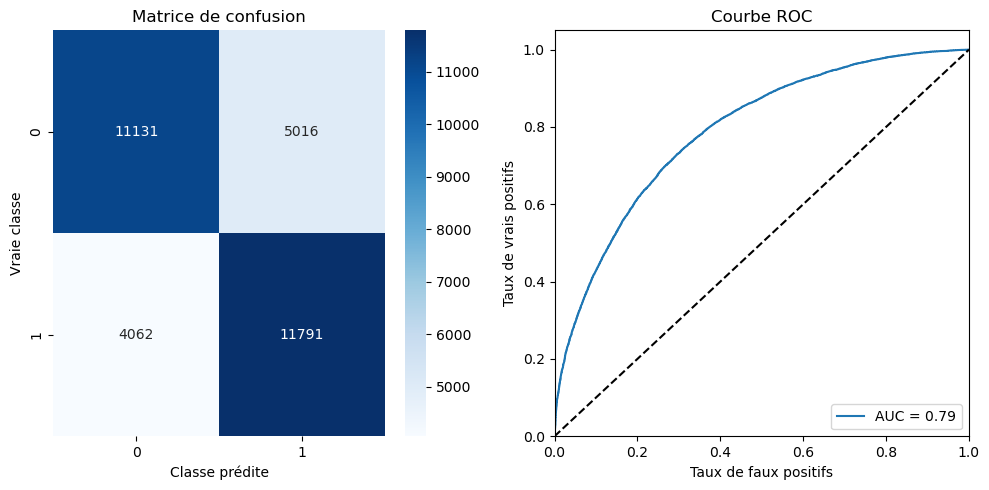

2024/12/16 20:53:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpp94iewc4/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpp94iewc4/model/data/model/assets
2024/12/16 20:53:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [4]:
#@title 3.2 Entraînement et évaluation du modèle MLP avec MLflow

import mlflow
import mlflow.keras

# Créer et entraîner le modèle MLP
model_mlp = model.create_mlp_model(input_shape=(X_train_w2v.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_mlp.fit(X_train_d2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_mlp, X_test_d2v, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)  # Ajout du predict_time

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "MLP")
    
    # Enregistrer le modèle
    mlflow.keras.log_model(model_mlp, "model_mlp")

### 3.3 - Modèle CNN

Epoch 1/10
3200/3200 [==============================] - 81s 25ms/step - loss: 0.6075 - accuracy: 0.6696 - val_loss: 0.5902 - val_accuracy: 0.6900
Epoch 2/10
3200/3200 [==============================] - 40s 13ms/step - loss: 0.5844 - accuracy: 0.6920 - val_loss: 0.5876 - val_accuracy: 0.6904
Epoch 3/10
3200/3200 [==============================] - 35s 11ms/step - loss: 0.5783 - accuracy: 0.6954 - val_loss: 0.5855 - val_accuracy: 0.6895
Epoch 4/10
3200/3200 [==============================] - 38s 12ms/step - loss: 0.5737 - accuracy: 0.6989 - val_loss: 0.5818 - val_accuracy: 0.6926
Epoch 5/10
3200/3200 [==============================] - 39s 12ms/step - loss: 0.5703 - accuracy: 0.7014 - val_loss: 0.5852 - val_accuracy: 0.6873
Epoch 6/10
3200/3200 [==============================] - 42s 13ms/step - loss: 0.5668 - accuracy: 0.7034 - val_loss: 0.5910 - val_accuracy: 0.6880
Epoch 7/10
3200/3200 [==============================] - 42s 13ms/step - loss: 0.5638 - accuracy: 0.7060 - val_loss: 0.5794 -

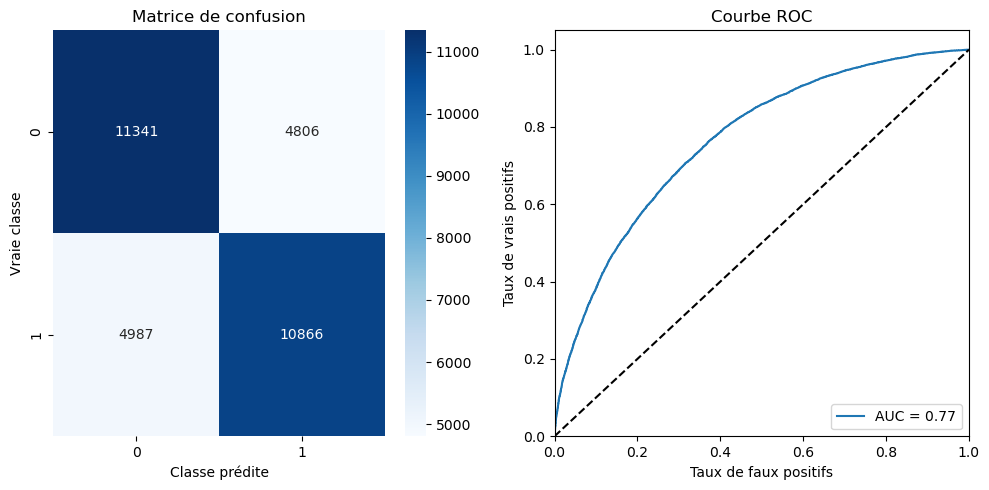

2024/12/16 21:01:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpcvv3rbaa/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpcvv3rbaa/model/data/model/assets
2024/12/16 21:01:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [5]:
#@title 3.3 Entraînement et évaluation du modèle CNN avec MLflow

import mlflow
import mlflow.keras

# Reshape les données pour le modèle CNN
X_train_cnn = np.reshape(X_train_d2v, (X_train_d2v.shape[0], X_train_d2v.shape[1], 1))
X_test_cnn = np.reshape(X_test_d2v, (X_test_d2v.shape[0], X_test_d2v.shape[1], 1))

# Créer le modèle CNN
model_cnn = model.create_cnn_model(input_shape=(X_train_cnn.shape[1], 1))

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_cnn, X_test_cnn, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score",  f1)
    mlflow.log_metric("predict_time", predict_time)  # Ajout du predict_time

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "CNN")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_cnn, "model_cnn")

### 3.4 - Modèle LSTM + Word2Vec + Optimisation Batch size

Epoch 1/10
6400/6400 [==============================] - 626s 97ms/step - loss: 0.5346 - accuracy: 0.7270 - val_loss: 0.5107 - val_accuracy: 0.7480
Epoch 2/10
6400/6400 [==============================] - 618s 97ms/step - loss: 0.5044 - accuracy: 0.7502 - val_loss: 0.5031 - val_accuracy: 0.7542
Epoch 3/10
6400/6400 [==============================] - 601s 94ms/step - loss: 0.4927 - accuracy: 0.7579 - val_loss: 0.4989 - val_accuracy: 0.7564
Epoch 4/10
6400/6400 [==============================] - 608s 95ms/step - loss: 0.4850 - accuracy: 0.7622 - val_loss: 0.4928 - val_accuracy: 0.7584
Epoch 5/10
6400/6400 [==============================] - 636s 99ms/step - loss: 0.4779 - accuracy: 0.7677 - val_loss: 0.4856 - val_accuracy: 0.7651
Epoch 6/10
6400/6400 [==============================] - 652s 102ms/step - loss: 0.4699 - accuracy: 0.7723 - val_loss: 0.4863 - val_accuracy: 0.7657
Epoch 7/10
6400/6400 [==============================] - 636s 99ms/step - loss: 0.4627 - accuracy: 0.7769 - val_loss: 

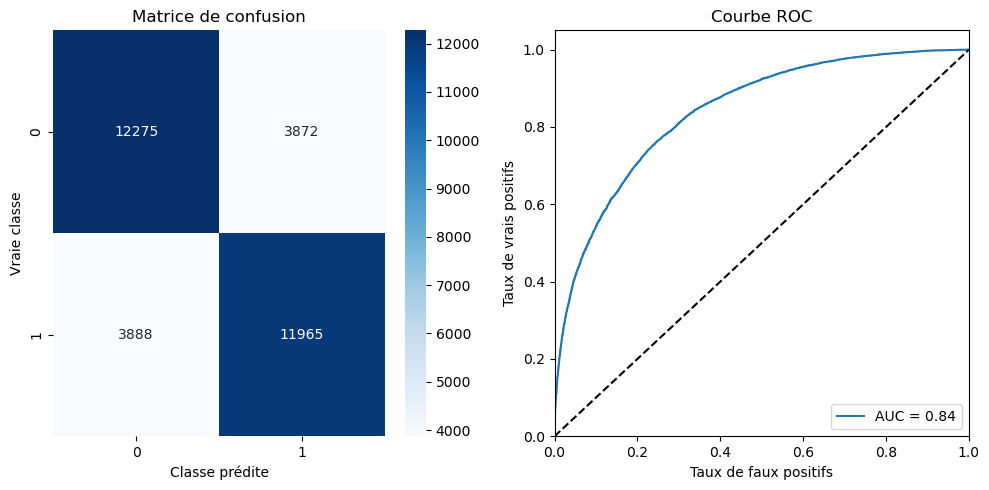

2024/12/16 22:46:45 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpk07vhj47/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpk07vhj47/model/data/model/assets
2024/12/16 22:46:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Epoch 1/10
3200/3200 [==============================] - 470s 146ms/step - loss: 0.5386 - accuracy: 0.7242 - val_loss: 0.5155 - val_accuracy: 0.7422
Epoch 2/10
3200/3200 [==============================] - 470s 147ms/step - loss: 0.5066 - accuracy: 0.7478 - val_loss: 0.4993 - val_accuracy: 0.7548
Epoch 3/10
3200/3200 [==============================] - 467s 146ms/step - loss: 0.4952 - accuracy: 0.7555 - val_loss: 0.4940 - val_accuracy: 0.7561
Epoch 4/10
3200/3200 [==============================] - 442s 138ms/step - loss: 0.4858 - accuracy: 0.7619 - val_loss: 0.4872 - val_accuracy: 0.7627
Epoch 5/10
3200/3200 [==============================] - 443s 138ms/step - loss: 0.4780 - accuracy: 0.7666 - val_loss: 0.4888 - val_accuracy: 0.7612
Epoch 6/10
3200/3200 [==============================] - 442s 138ms/step - loss: 0.4711 - accuracy: 0.7711 - val_loss: 0.4860 - val_accuracy: 0.7645
Epoch 7/10
3200/3200 [==============================] - 444s 139ms/step - loss: 0.4630 - accuracy: 0.7771 - val_

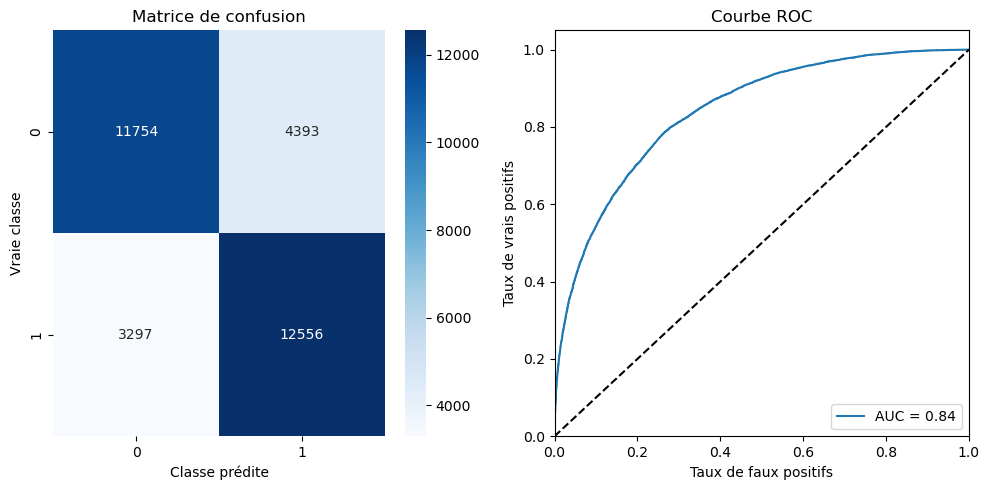

2024/12/17 00:03:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp6ape9o1w/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp6ape9o1w/model/data/model/assets
2024/12/17 00:03:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Epoch 1/10
1600/1600 [==============================] - 325s 202ms/step - loss: 0.5452 - accuracy: 0.7197 - val_loss: 0.5156 - val_accuracy: 0.7424
Epoch 2/10
1600/1600 [==============================] - 333s 208ms/step - loss: 0.5129 - accuracy: 0.7448 - val_loss: 0.5062 - val_accuracy: 0.7491
Epoch 3/10
1600/1600 [==============================] - 322s 201ms/step - loss: 0.5013 - accuracy: 0.7520 - val_loss: 0.4967 - val_accuracy: 0.7550
Epoch 4/10
1600/1600 [==============================] - 322s 201ms/step - loss: 0.4939 - accuracy: 0.7568 - val_loss: 0.5109 - val_accuracy: 0.7446
Epoch 5/10
1600/1600 [==============================] - 322s 201ms/step - loss: 0.4859 - accuracy: 0.7623 - val_loss: 0.4909 - val_accuracy: 0.7591
Epoch 6/10
1600/1600 [==============================] - 329s 206ms/step - loss: 0.4795 - accuracy: 0.7646 - val_loss: 0.4881 - val_accuracy: 0.7623
Epoch 7/10
1600/1600 [==============================] - 322s 201ms/step - loss: 0.4725 - accuracy: 0.7700 - val_

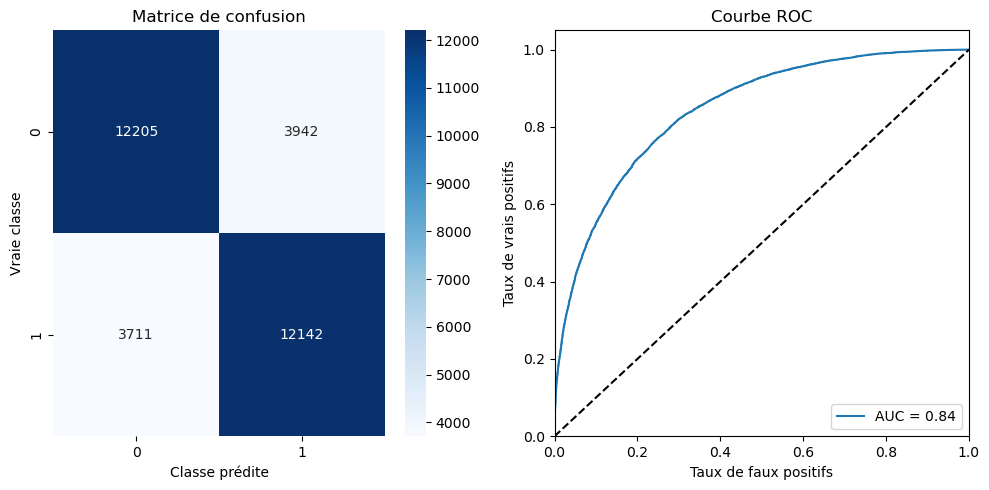

2024/12/17 00:59:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpixauzc9y/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpixauzc9y/model/data/model/assets
2024/12/17 00:59:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Epoch 1/10
800/800 [==============================] - 254s 315ms/step - loss: 0.5527 - accuracy: 0.7114 - val_loss: 0.5207 - val_accuracy: 0.7364
Epoch 2/10
800/800 [==============================] - 251s 314ms/step - loss: 0.5183 - accuracy: 0.7401 - val_loss: 0.5071 - val_accuracy: 0.7496
Epoch 3/10
800/800 [==============================] - 253s 316ms/step - loss: 0.5059 - accuracy: 0.7489 - val_loss: 0.5002 - val_accuracy: 0.7545
Epoch 4/10
800/800 [==============================] - 253s 316ms/step - loss: 0.4972 - accuracy: 0.7549 - val_loss: 0.4977 - val_accuracy: 0.7533
Epoch 5/10
800/800 [==============================] - 253s 316ms/step - loss: 0.4897 - accuracy: 0.7584 - val_loss: 0.4912 - val_accuracy: 0.7609
Epoch 6/10
800/800 [==============================] - 253s 316ms/step - loss: 0.4841 - accuracy: 0.7634 - val_loss: 0.4946 - val_accuracy: 0.7591
Epoch 7/10
800/800 [==============================] - 253s 316ms/step - loss: 0.4790 - accuracy: 0.7659 - val_loss: 0.4907 -

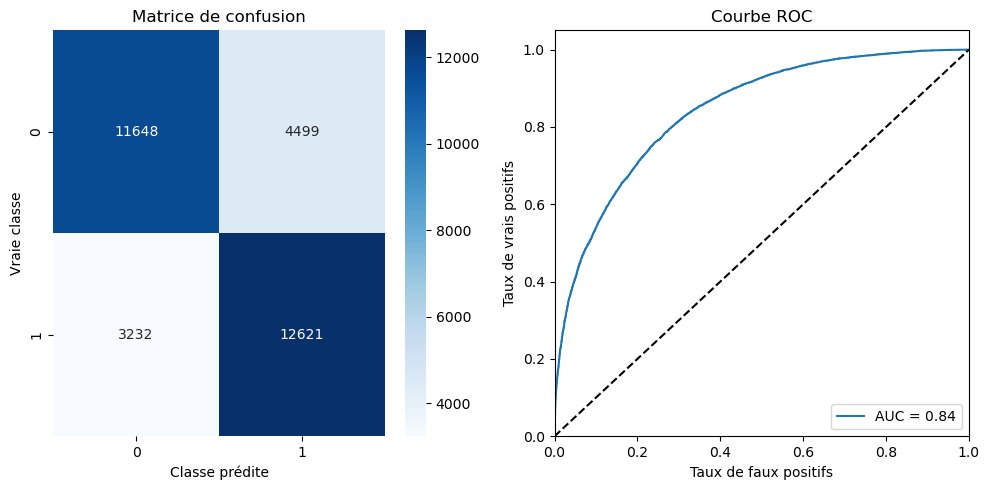

2024/12/17 01:43:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpbprp9jq9/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpbprp9jq9/model/data/model/assets
2024/12/17 01:43:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Meilleur batch_size : 64


In [6]:
#@title 3.8 Entraînement et évaluation du modèle LSTM avec Word2Vec et MLflow (optimisation du batch_size)

import mlflow
import mlflow.keras
from gensim.models import Word2Vec

# Entraîner le modèle Word2Vec sur les tweets prétraités
sentences = [tweet.split() for tweet in X_train]
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Créer la matrice d'embedding
embedding_matrix = np.zeros((len(model_w2v.wv), 100))

# Itérer sur les mots du vocabulaire
for i, word in enumerate(model_w2v.wv.index_to_key):  # Utiliser index_to_key pour obtenir les mots
    embedding_matrix[i] = model_w2v.wv[word]

# Entraîner le modèle sur les données d'entraînement
X_train_w2v = [[model_w2v.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_train]
X_test_w2v = [[model_w2v.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_test]

# Remplir les séquences avec des zéros pour qu'elles aient toutes la même longueur
max_length = 100  # Définir la longueur maximale des séquences
X_train_w2v = pad_sequences(X_train_w2v, maxlen=max_length)
X_test_w2v = pad_sequences(X_test_w2v, maxlen=max_length)

# Définir les valeurs de batch_size à tester
batch_sizes = [16, 32, 64, 128]

# Initialiser le meilleur batch_size et la meilleure accuracy
best_batch_size = None
best_accuracy = 0.0

for batch_size in batch_sizes:
    with mlflow.start_run():
        # Créer le modèle LSTM
        model_lstm = model.create_lstm_model(input_shape=(embedding_matrix.shape[0], embedding_matrix.shape[1]),
                                            embedding_matrix = embedding_matrix)

        # Entraîner le modèle avec le batch_size actuel
        model_lstm.fit(X_train_w2v, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

        # Évaluer le modèle et récupérer les métriques
        accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lstm, X_test_w2v, y_test)

        # Enregistrer les paramètres
        mlflow.log_param("model", "LSTM")
        mlflow.log_param("embedding", "Word2Vec")
        mlflow.log_param("epochs", 10)
        mlflow.log_param("batch_size", batch_size)

        # Enregistrer les métriques
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("predict_time", predict_time)

        # Ajouter un tag pour identifier le modèle
        mlflow.set_tag("model_name", "LSTM_w2v")

        # Enregistrer le modèle
        mlflow.keras.log_model(model_lstm, "model_lstm_w2v")

        # Mettre à jour le meilleur batch_size et la meilleure accuracy si nécessaire
        if accuracy > best_accuracy:
            best_batch_size = batch_size
            best_accuracy = accuracy

# Afficher le meilleur batch_size
print(f"Meilleur batch_size : {best_batch_size}")

### 3.5 - Modèle LSTM + Embeddding FastText

model_ft = FastText(sentences, vector_size=100, window=5, min_count=1, workers=4)

Le code ci-dessus crée un modèle Word2Vec en utilisant la librairie Gensim. Voici une explication des paramètres :

*   `sentences` : une liste de phrases tokenisées qui seront utilisées pour entraîner le modèle.
*   `vector_size` : la dimensionnalité des vecteurs de mots (word embeddings). Ici, chaque mot sera représenté par un vecteur de 100 dimensions.
*   `window` : la taille de la fenêtre de contexte. Le modèle va considérer 5 mots avant et 5 mots après chaque mot pour apprendre les relations entre les mots.
*   `min_count` : le nombre minimum d’occurrences d’un mot pour qu’il soit pris en compte dans le vocabulaire. Ici, tous les mots seront utilisés car `min_count=1`.
*   `workers` : le nombre de cœurs de processeur à utiliser pour l’entraînement.


Epoch 1/10
3200/3200 [==============================] - 434s 135ms/step - loss: 0.5437 - accuracy: 0.7198 - val_loss: 0.5190 - val_accuracy: 0.7377
Epoch 2/10
3200/3200 [==============================] - 432s 135ms/step - loss: 0.5137 - accuracy: 0.7426 - val_loss: 0.5028 - val_accuracy: 0.7498
Epoch 3/10
3200/3200 [==============================] - 433s 135ms/step - loss: 0.5011 - accuracy: 0.7514 - val_loss: 0.4974 - val_accuracy: 0.7551
Epoch 4/10
3200/3200 [==============================] - 433s 135ms/step - loss: 0.4905 - accuracy: 0.7585 - val_loss: 0.4965 - val_accuracy: 0.7563
Epoch 5/10
3200/3200 [==============================] - 441s 138ms/step - loss: 0.4814 - accuracy: 0.7648 - val_loss: 0.4935 - val_accuracy: 0.7544
Epoch 6/10
3200/3200 [==============================] - 432s 135ms/step - loss: 0.4719 - accuracy: 0.7707 - val_loss: 0.4946 - val_accuracy: 0.7579
Epoch 7/10
3200/3200 [==============================] - 436s 136ms/step - loss: 0.4614 - accuracy: 0.7752 - val_

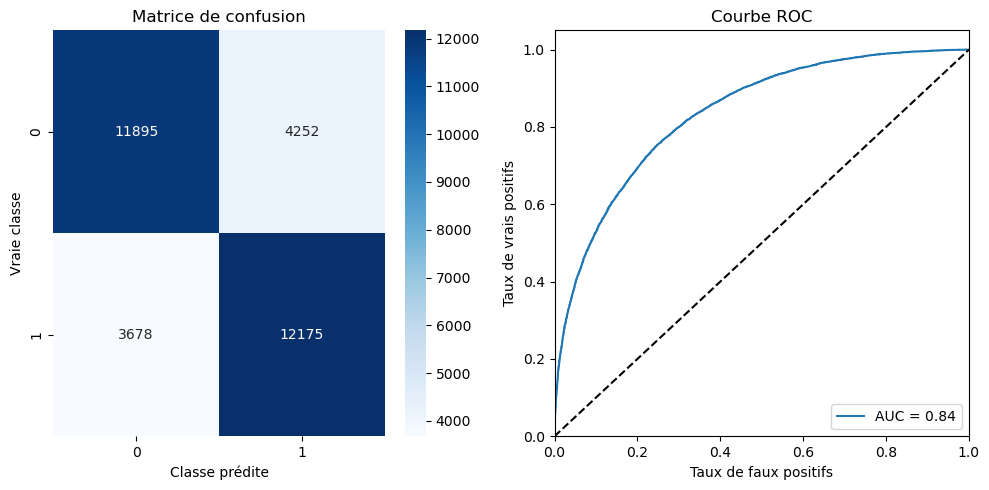

2024/12/17 02:58:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpfwq0rtkw/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpfwq0rtkw/model/data/model/assets
2024/12/17 02:58:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [7]:
#@title 3.7 Entraînement et évaluation du modèle LSTM avec FastText et MLflow

import mlflow
import mlflow.keras
from gensim.models import FastText

# Entraîner le modèle FastText sur les tweets prétraités
sentences = [tweet.split() for tweet in X_train]

vec_size = 100
model_ft = FastText(sentences, vector_size=vec_size, window=5, min_count=1, workers=4)

# Créer la matrice d'embedding
embedding_matrix = np.zeros((len(model_ft.wv), vec_size))  # Forme (vocab_size, vec_size)

# Itérer sur les mots du vocabulaire
for i, word in enumerate(model_ft.wv.index_to_key):  # Utiliser index_to_key pour obtenir les mots
    embedding_matrix[i] = model_ft.wv[word]

# Définir le modèle LSTM avec la couche d'embedding FastText
model_lstm_ft = model.create_lstm_model(input_shape=(embedding_matrix.shape[0], embedding_matrix.shape[1]),
                                       embedding_matrix= embedding_matrix)

# Entraîner le modèle sur les données d'entraînement
X_train_ft = [[model_ft.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_train]
X_test_ft = [[model_ft.wv.key_to_index.get(word, 0) for word in tweet.split()] for tweet in X_test]

# Remplir les séquences avec des zéros pour qu'elles aient toutes la même longueur
max_length = 100  # Définir la longueur maximale des séquences
X_train_ft = pad_sequences(X_train_ft, maxlen=max_length)
X_test_ft = pad_sequences(X_test_ft, maxlen=max_length)

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    history = model_lstm_ft.fit(X_train_ft, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_lstm_ft, X_test_ft, y_test)

    # Enregistrer les paramètres
    mlflow.log_param("model", "LSTM")
    mlflow.log_param("embedding", "FastText")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "LSTM_ft")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_lstm_ft, "model_lstm_ft")

### 3.6 - Modèle BERT

In [ ]:
#@title 3.5 Entraînement et évaluation du modèle BERT avec MLflow

import mlflow
import mlflow.keras

# Créer et entraîner le modèle BERT
model_bert, tokenizer = model.create_bert_model("bert-base-uncased")

# Tokenizer les tweets d'entraînement et de test
X_train_bert = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="tf")
X_test_bert = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="tf")

# Convertir les labels en tenseurs
y_train_bert = tf.convert_to_tensor(y_train)
y_test_bert = tf.convert_to_tensor(y_test)

# Hyperparamètres
batch_size = 16
epochs = 3

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    history = model_bert.fit(
        x={"input_ids": X_train_bert["input_ids"], "attention_mask": X_train_bert["attention_mask"]},
        y=y_train_bert,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
    )

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_bert, 
                                  {"input_ids": X_test_bert["input_ids"], "attention_mask": X_test_bert["attention_mask"]}, 
                                      y_test_bert)

    # Enregistrer les paramètres
    mlflow.log_param("model", "BERT")
    mlflow.log_param("model_name", "bert-base-uncased")
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score",  f1)
    mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "BERT")

    # Enregistrer le modèle
    mlflow.keras.log_model(model_bert, "model_bert")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
219/640 [=========>....................] - ETA: 40:15 - loss: 0.7552 - accuracy: 0.4989

### 3.7 - Modèle USE

2024-12-17 09:29:57.629417: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2831418880 exceeds 10% of free system memory.
2024-12-17 09:30:03.094698: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 707425280 exceeds 10% of free system memory.


Epoch 1/10
3200/3200 [==============================] - 9s 3ms/step - loss: 0.5163 - accuracy: 0.7456 - val_loss: 0.4986 - val_accuracy: 0.7562
Epoch 2/10
3200/3200 [==============================] - 9s 3ms/step - loss: 0.5001 - accuracy: 0.7559 - val_loss: 0.4920 - val_accuracy: 0.7606
Epoch 3/10
3200/3200 [==============================] - 9s 3ms/step - loss: 0.4916 - accuracy: 0.7613 - val_loss: 0.4875 - val_accuracy: 0.7638
Epoch 4/10
3200/3200 [==============================] - 8s 3ms/step - loss: 0.4847 - accuracy: 0.7666 - val_loss: 0.4864 - val_accuracy: 0.7629
Epoch 5/10
3200/3200 [==============================] - 8s 3ms/step - loss: 0.4796 - accuracy: 0.7697 - val_loss: 0.4841 - val_accuracy: 0.7632
Epoch 6/10
3200/3200 [==============================] - 9s 3ms/step - loss: 0.4737 - accuracy: 0.7739 - val_loss: 0.4841 - val_accuracy: 0.7645
Epoch 7/10
3200/3200 [==============================] - 9s 3ms/step - loss: 0.4690 - accuracy: 0.7769 - val_loss: 0.4844 - val_accuracy:

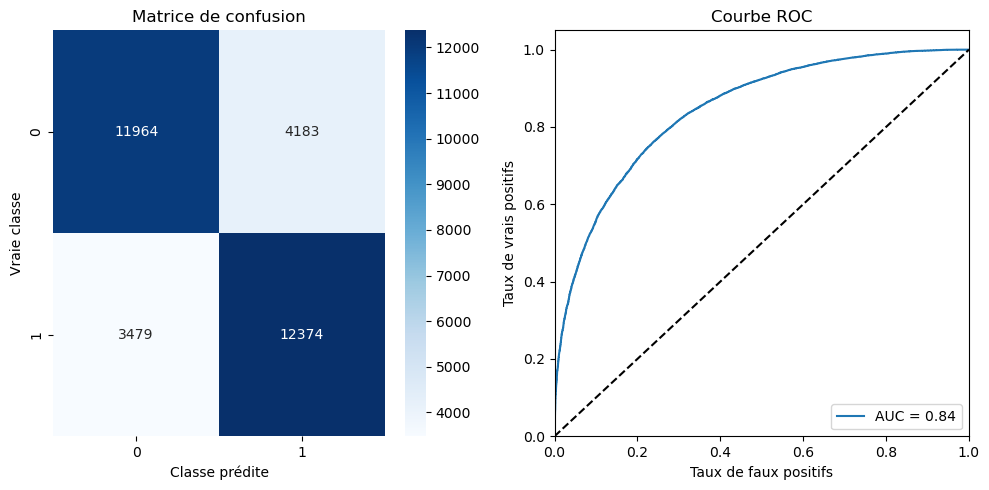

2024/12/17 09:31:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp_xadv4bn/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp_xadv4bn/model/data/model/assets
/home/mehdi/miniconda3/envs/sentiment_analysis/lib/python3.8/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/12/17 09:31:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [3]:
#@title 3.6 Entraînement et évaluation du modèle USE avec MLflow

import mlflow
import mlflow.keras
import tensorflow_hub as hub

# Charger le modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Encoder les tweets
X_train_use = embed(X_train)
X_test_use = embed(X_test)

# Créer le modèle USE
model_use = model.create_use_model(input_shape=(X_train_use.shape[1],))

# Démarrer une exécution MLflow
with mlflow.start_run():
    # Entraîner le modèle
    model_use.fit(X_train_use, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Évaluer le modèle et récupérer les métriques
    accuracy, precision, recall, f1, predict_time = evaluation.evaluer_modele(model_use, X_test_use, y_test)

    # Enregistrer les paramètres
    # (Ajouter ici les paramètres du modèle USE)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("predict_time", predict_time)

    # Ajouter un tag pour identifier le modèle
    mlflow.set_tag("model_name", "USE")
    
    # Enregistrer le modèle
    mlflow.keras.log_model(model_use, "model_use")

## 4. Comparaison des modèles

In [ ]:
#@title Comparaison des modèles avec MLflow

import mlflow

# Fonction pour récupérer les métriques d'une exécution MLflow
def get_metrics_from_mlflow(model_name):
    # Rechercher l'exécution avec le tag "model_name"
    runs = mlflow.search_runs(filter_string=f"tag.model_name = '{model_name}'")
    if runs.empty:
        raise ValueError(f"Aucune exécution trouvée avec le tag 'model_name' = '{model_name}'")

    # Récupérer les métriques de la dernière exécution
    last_run = runs.iloc[-1]
    return (last_run["metrics.accuracy"], 
            last_run["metrics.precision"],
            last_run["metrics.recall"],
            last_run["metrics.f1_score"], 
            last_run["metrics.predict_time"])

# Comparaison des modèles
noms_modeles = ['LogisticRegression', 'MLP', 'LSTM_w2v', 'LSTM_ft', 'CNN', 'BERT', 'USE']

# Calculer les métriques pour chaque modèle
resultats = []
for model_name in noms_modeles:
    resultats.append(get_metrics_from_mlflow(model_name))

# Créer un DataFrame pour afficher les résultats
comparaison = pd.DataFrame(resultats, columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'Predict Time'], index=noms_modeles)

# Afficher les résultats
print(comparaison)